In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

import numpy as np

import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
from PIL import Image 
from scipy import ndimage, misc
import matplotlib.pyplot as plt

from image_feature_extractor import Img2Vec

from sklearn.linear_model import LogisticRegression

import torch
from sklearn import preprocessing

# import seaborn as sns

from scipy.ndimage import gaussian_filter

# Download CIFAR 10 data form torchvision

In [2]:

train_dataset = torchvision.datasets.CIFAR10('~/datasets/cifar', train=True, download=True)
test_dataset = torchvision.datasets.CIFAR10('~/datasets/cifar', train=False, download=True)


Files already downloaded and verified
Files already downloaded and verified


# Useful functions

In [3]:
def apply_contrast(images_data, contrast_factor):
    to_tensor = transforms.ToTensor()   
    images_list = [to_tensor(im) for im in images_data]
    images = torch.stack(images_list)
    contrasted_images = F.adjust_contrast(images, contrast_factor)
    contrasted_images = np.array(np.stack([transforms.ToPILImage()(im) for im in contrasted_images]))
    return contrasted_images

def apply_rotation(images_data, angle=30):
    rotated_images = []
    for img in images_data:
        rotated_image = ndimage.rotate(img, angle, reshape=False)
        rotated_images.append(rotated_image)
    rotated_images = np.array(rotated_images)
    return rotated_images

def blur_images(images_data, sigma=1):
    blurred_images = []
    for img in images_data:
        blurred_image = gaussian_filter(img, sigma)
        blurred_images.append(blurred_image)
    blurred_images = np.array(blurred_images)
    return blurred_images


# Generate a list of original and duplicate modified images: every original image has a duplicate which is 
# the modified original image.
def generate_list_of_original_and_its_duplicate_modified_images(image_set, mod_factor, mod_type="contrast"):
    original_labels = np.zeros(len(image_set.data))
    modified_labels = np.ones(len(image_set.data))
    
    modified_images = None
    
    if mod_type=="contrast":
        modified_images = apply_contrast(image_set.data, mod_factor) 
        
    elif mod_type=="rotation":
        modified_images = apply_rotation(image_set.data, mod_factor)
    
    elif mod_type=="blur":
        modified_images = blur_images(image_set.data, mod_factor)

    original_and_modified_images = np.concatenate((image_set.data, modified_images), axis=0)
    modification_labels = np.concatenate((original_labels, modified_labels), axis=None)
    image_labels = np.concatenate((image_set.targets, image_set.targets), axis=None)        
    return modified_images, original_and_modified_images, modification_labels, image_labels



# Generate a list of original and copies of its modified images combined: every original image has other 
# copies of itself on which different types of transformations/modifications have been applied. 
def generate_list_of_original_and_copies_of_its_modified_images(image_set, contrast_factor=0.3, angle=30, sigma=1):
    original_labels = np.zeros(len(image_set.data))
    modified_labels1 = np.ones(len(image_set.data))
    modified_labels2 = np.array([2]*len(image_set.data))
    modified_labels3 = np.array([3]*len(image_set.data))

    modified_images1 = apply_contrast(image_set.data, contrast_factor) 

    modified_images2 = apply_rotation(image_set.data, angle)
    
    modified_images3 = blur_images(image_set.data, sigma)

    original_and_modified_images = np.concatenate((image_set.data, modified_images1, modified_images2,modified_images3), axis=0)
    modification_labels = np.concatenate((original_labels, modified_labels1, modified_labels2,modified_labels3), axis=None)
    image_labels = np.concatenate((image_set.targets, image_set.targets, image_set.targets,image_set.targets), axis=None)        
    return original_and_modified_images, modification_labels, image_labels




# used to binarize the target variable
def binarize(y):    
    y = np.copy(y) > 5
    return y.astype(int)

def correlate_label_with_img_modification(image_dataset, mod_factor, mod_percent= 0.1, 
                                          binarize_label=True, mod_type="contrast"):
    y = binarize(image_dataset.targets)
    mod_labels = np.logical_xor(y, np.random.binomial(1, mod_percent, size=len(y)))
    
    images_to_be_modified = image_dataset.data[mod_labels]
    images_to_be_left_alone = image_dataset.data[~mod_labels]
    
    all_img_labels = None
    
    if binarize_label:
        modified_imgs_labels = y[mod_labels]
        unmodified_imgs_labels = y[~mod_labels]
        all_img_labels = np.concatenate((modified_imgs_labels, unmodified_imgs_labels), axis=None)
    else:
        modified_imgs_labels = np.array(image_dataset.targets)[mod_labels]
        unmodified_imgs_labels = np.array(image_dataset.targets)[~mod_labels]
        all_img_labels = np.concatenate((modified_imgs_labels, unmodified_imgs_labels), axis=None)    
    
    all_images = None
    
    if mod_type == "contrast":
        modified_images = apply_contrast(images_to_be_modified, mod_factor)
        all_images = np.concatenate((modified_images, images_to_be_left_alone), axis=0)                    
        
    elif mod_type=="rotation":
        modified_images = apply_rotation(images_to_be_modified, mod_factor)
        all_images = np.concatenate((modified_images, images_to_be_left_alone), axis=0)
        
    return all_images, all_img_labels, mod_labels.astype(int)


# Function to extract image features    
def get_features(images, batch_size):
    Z_list = []
#     img2vec = Img2Vec(model="resnet50")
    img2vec = Img2Vec()
    for first in range(0, len(images), batch_size):
        images_subset = images[first:first+batch_size]
        Z_subset = img2vec.get_vec(images_subset)
        Z_list.append(Z_subset)
    Z = np.vstack(Z_list)
    return Z

# Visualize Blurred Image. Change sigma value to increase or decrease blur strength

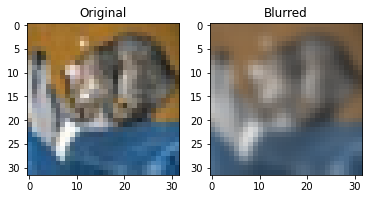

In [4]:
fig = plt.figure()
ax1 = fig.add_subplot(121)  
ax1.set_title("Original")
ax2 = fig.add_subplot(122) 
ax2.set_title("Blurred")
img = test_dataset.data[0]
blurred = gaussian_filter(img, sigma=1)
ax1.imshow(img)
ax2.imshow(blurred)
plt.show()

In [5]:
contrast_factor = 0.3
angle = 15
sigma = 1
batch_size = 64
dist_value = 1.0

# Creating a set of images to be used to obtain L
all_images, mod_labels, img_labels = generate_list_of_original_and_copies_of_its_modified_images(
    train_dataset, contrast_factor, angle, sigma)


# Creating sets of images in a way that correlates the way images are modified with label
train_imgs, train_labels2, train_mod_labels2 = correlate_label_with_img_modification(
    train_dataset, angle, mod_percent= dist_value, binarize_label=False, mod_type="rotation")

test_imgs_indist, test_labels2_indist, test_mod_labels2_indist = correlate_label_with_img_modification(
    test_dataset, angle, mod_percent= dist_value, binarize_label=False, mod_type="rotation")

test_imgs_ood, test_labels2_ood, test_mod_labels2_ood = correlate_label_with_img_modification(
    test_dataset, angle, mod_percent= 1-dist_value, binarize_label=False, mod_type="rotation")

# creating duplicates of rotated and unrotated images
t_mod_imgs, t_imgs, t_mod_labels, t_labels = generate_list_of_original_and_its_duplicate_modified_images(
    test_dataset, angle, mod_type="rotation")

print(all_images.shape)
print(train_imgs.shape)

(200000, 32, 32, 3)
(50000, 32, 32, 3)


# Extract Image Features

In [6]:
# mod_labels[mod_labels==3]

# Extract image features
Z = get_features(all_images, batch_size)
Z_train = get_features(train_imgs, batch_size)
Z_test_indist= get_features(test_imgs_indist, batch_size)
Z_test_ood= get_features(test_imgs_ood, batch_size)

Z_test_original = get_features(test_dataset.data, batch_size)
Z_test_contrasted = get_features(t_mod_imgs, batch_size)
Z_test_og_rotated = get_features(t_imgs, batch_size)

# mod_labels


# Obtaining prediction coefficients and prediction accuracy of transformations done on images

In [7]:
# Using sklearn Logistic Regression
from sklearn.linear_model import LogisticRegression

# not_1_and_2 = (mod_labels !=1) & (mod_labels !=2) # 0 (original) and 3 (blurred)
not_1_and_3 = (mod_labels !=1) & (mod_labels !=3) # 0 (original) and 2 (rotated)
not_2_and_3 = (mod_labels !=2) & (mod_labels !=3) # 0 (original) and 1 (contrasted)

Z_og_rotated = Z[not_1_and_3]
rotation_labels = mod_labels[not_1_and_3]

Z_og_contrasted = Z[not_2_and_3]
contrast_labels =  mod_labels[not_2_and_3]

lr_model_contrast = LogisticRegression(random_state=0).fit(Z_og_contrasted, contrast_labels)
contrast_coefficients = lr_model_contrast.coef_.reshape(-1,1)
theta_1 = contrast_coefficients / np.linalg.norm(contrast_coefficients)

theta_1_theta_1_T = theta_1 @ theta_1.T
d = theta_1_theta_1_T.shape[0]
I = np.identity(d)
I_minus_theta_1_theta_1_T = I-theta_1_theta_1_T


lr_model_rotation = LogisticRegression(random_state=0).fit((Z_og_rotated @ I_minus_theta_1_theta_1_T), 
                                                           rotation_labels)
rotation_coefficients = lr_model_rotation.coef_.reshape(-1,1)
theta_2 = rotation_coefficients / np.linalg.norm(rotation_coefficients)


print('Train rotation prediction accuracy: ', lr_model_rotation.score(Z_og_rotated, rotation_labels))
print('Test rotation prediction accuracy: ', lr_model_rotation.score(Z_test_og_rotated, t_mod_labels))


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mod

Train rotation prediction accuracy:  0.99844
Test rotation prediction accuracy:  0.49855


# Prediction Accuracies on extracted image features Z ( features obtained from the feature extractor)

In [8]:
# Classification and recording prediction accuracy
logistic_regression_model2 = LogisticRegression(
    multi_class='multinomial', solver='lbfgs', random_state=0).fit(Z_train, 
                                                                   train_labels2)
accuracy0 = logistic_regression_model2.score(Z_train, train_labels2)
accuracy1 = logistic_regression_model2.score(Z_test_indist, test_labels2_indist)
accuracy2 = logistic_regression_model2.score(Z_test_ood, test_labels2_ood)
print('LR Training Accuracy: ', accuracy0)
print('LR Accuracy on test data - Z - In Dist: ', accuracy1)
print('LR Accuracy on test data - Z - OOD: ', accuracy2)


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Training Accuracy:  0.91384
LR Accuracy on test data - Z - In Dist:  0.8967
LR Accuracy on test data - Z - OOD:  0.1032


# Find L, get F features, plot histograms and perform predictions

Results for lamda  0.001

Histogram for F Test feature  0


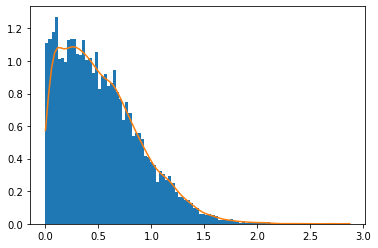

Histogram for F Test feature  1


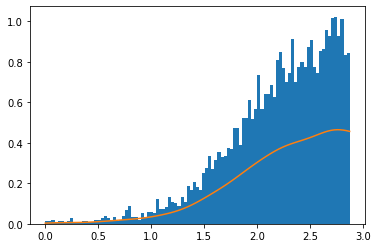

Histogram for F Test feature  2


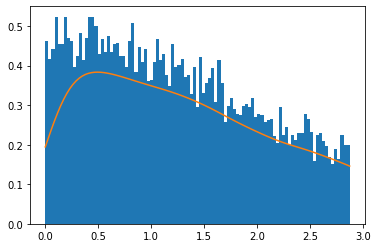

Histogram for F Test feature  3


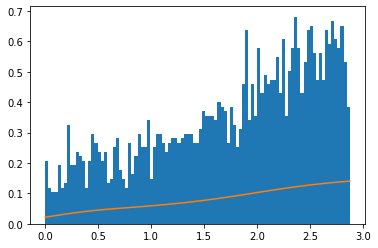

Histogram for F Test feature  4


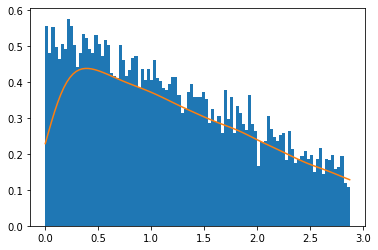

Histogram for F Test feature  5


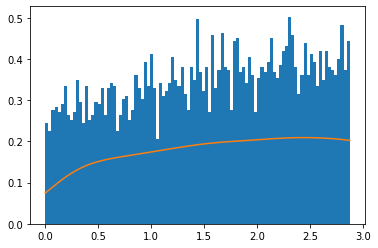

Histogram for F Test feature  6


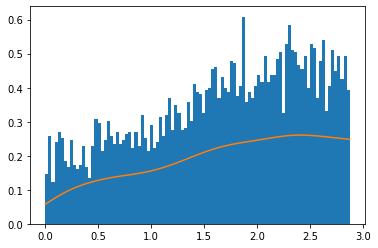

Histogram for F Test feature  7


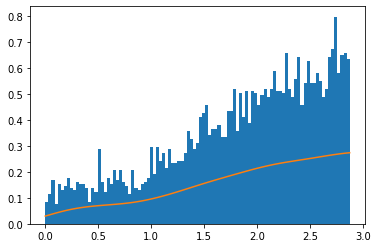

Histogram for F Test feature  8


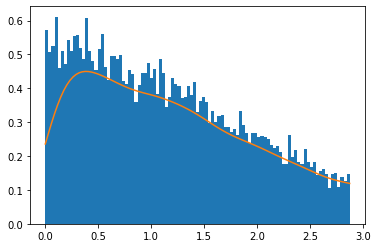

Histogram for F Test feature  9


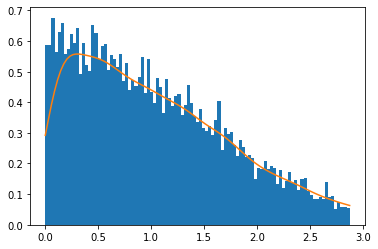

/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Training Accuracy - F:  0.90686
LR Accuracy on test data - F - In Dist:  0.8943
LR Accuracy on test data - F - OOD:  0.1164



Accuracy for without F feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Training Accuracy - F:  0.90614
LR Accuracy on test data - F - In Dist:  0.8935
LR Accuracy on test data - F - OOD:  0.1172


Accuracy for without F feature  1


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Training Accuracy - F:  0.90524
LR Accuracy on test data - F - In Dist:  0.8934
LR Accuracy on test data - F - OOD:  0.1415


Accuracy for without F feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Training Accuracy - F:  0.91072
LR Accuracy on test data - F - In Dist:  0.8937
LR Accuracy on test data - F - OOD:  0.1014


Accuracy for without F feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Training Accuracy - F:  0.9051
LR Accuracy on test data - F - In Dist:  0.8915
LR Accuracy on test data - F - OOD:  0.1428


Accuracy for without F feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Training Accuracy - F:  0.90322
LR Accuracy on test data - F - In Dist:  0.8903
LR Accuracy on test data - F - OOD:  0.1186









Results for lamda  0.01

Histogram for F Test feature  0


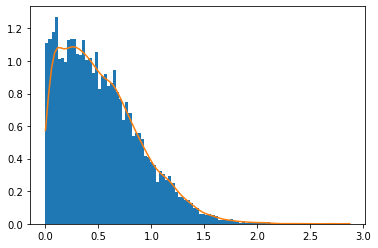

Histogram for F Test feature  1


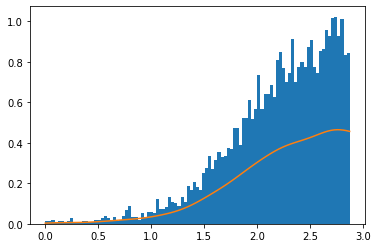

Histogram for F Test feature  2


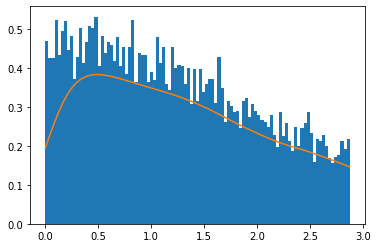

Histogram for F Test feature  3


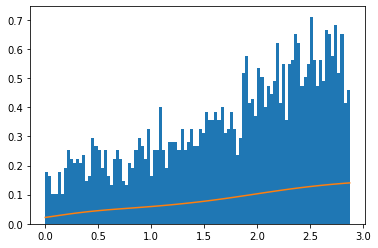

Histogram for F Test feature  4


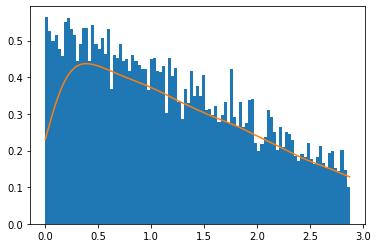

Histogram for F Test feature  5


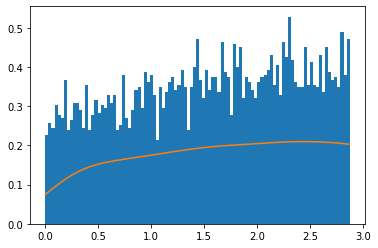

Histogram for F Test feature  6


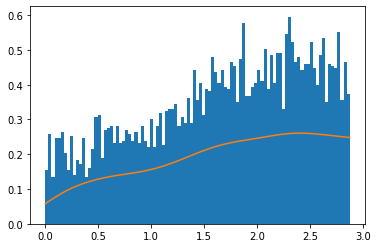

Histogram for F Test feature  7


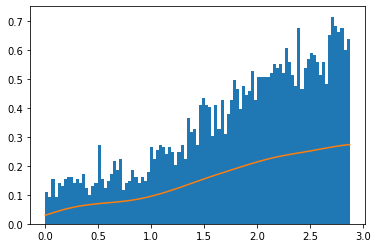

Histogram for F Test feature  8


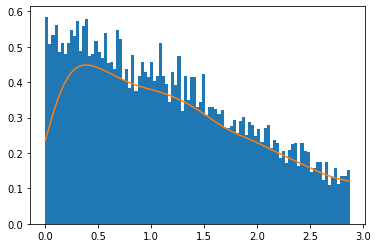

Histogram for F Test feature  9


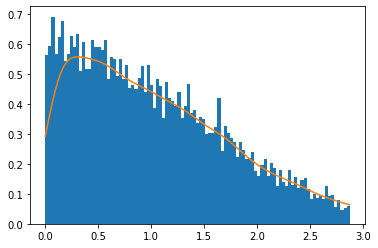

/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Training Accuracy - F:  0.90678
LR Accuracy on test data - F - In Dist:  0.8942
LR Accuracy on test data - F - OOD:  0.1167



Accuracy for without F feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Training Accuracy - F:  0.90638
LR Accuracy on test data - F - In Dist:  0.895
LR Accuracy on test data - F - OOD:  0.1257


Accuracy for without F feature  1


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Training Accuracy - F:  0.9058
LR Accuracy on test data - F - In Dist:  0.8932
LR Accuracy on test data - F - OOD:  0.1407


Accuracy for without F feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Training Accuracy - F:  0.91072
LR Accuracy on test data - F - In Dist:  0.8943
LR Accuracy on test data - F - OOD:  0.0988


Accuracy for without F feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Training Accuracy - F:  0.90572
LR Accuracy on test data - F - In Dist:  0.8921
LR Accuracy on test data - F - OOD:  0.1505


Accuracy for without F feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Training Accuracy - F:  0.90304
LR Accuracy on test data - F - In Dist:  0.891
LR Accuracy on test data - F - OOD:  0.1164









Results for lamda  10

Histogram for F Test feature  0


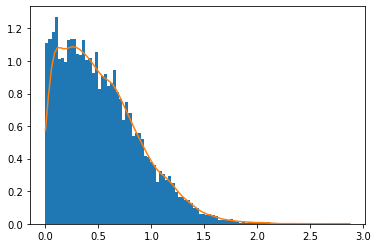

Histogram for F Test feature  1


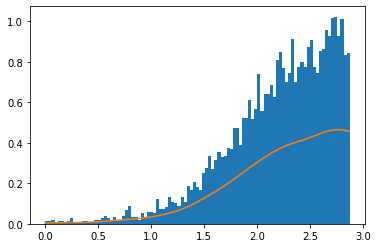

Histogram for F Test feature  2


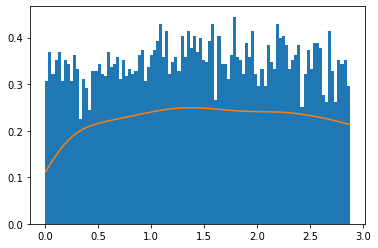

Histogram for F Test feature  3


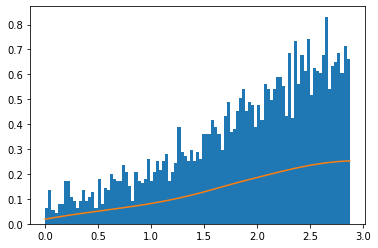

Histogram for F Test feature  4


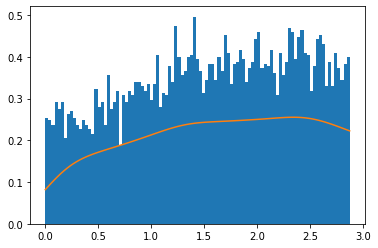

Histogram for F Test feature  5


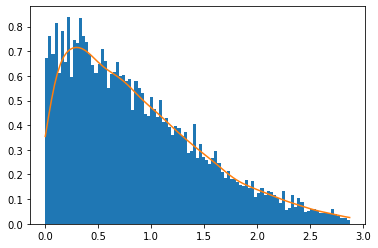

Histogram for F Test feature  6


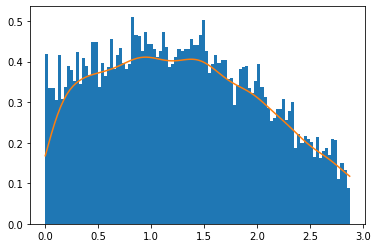

Histogram for F Test feature  7


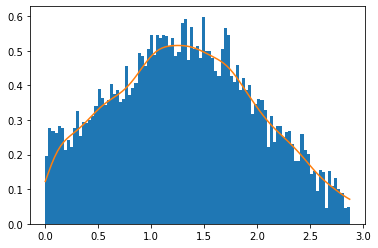

Histogram for F Test feature  8


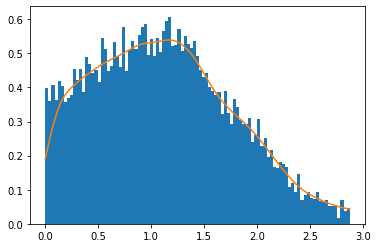

Histogram for F Test feature  9


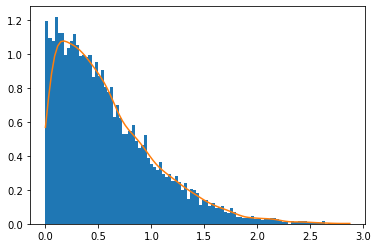

/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Training Accuracy - F:  0.87852
LR Accuracy on test data - F - In Dist:  0.8641
LR Accuracy on test data - F - OOD:  0.0547



Accuracy for without F feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Training Accuracy - F:  0.87726
LR Accuracy on test data - F - In Dist:  0.8623
LR Accuracy on test data - F - OOD:  0.0599


Accuracy for without F feature  1


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Training Accuracy - F:  0.87594
LR Accuracy on test data - F - In Dist:  0.8605
LR Accuracy on test data - F - OOD:  0.0941


Accuracy for without F feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Training Accuracy - F:  0.88264
LR Accuracy on test data - F - In Dist:  0.863
LR Accuracy on test data - F - OOD:  0.0435


Accuracy for without F feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Training Accuracy - F:  0.87744
LR Accuracy on test data - F - In Dist:  0.8625
LR Accuracy on test data - F - OOD:  0.0525


Accuracy for without F feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Training Accuracy - F:  0.87682
LR Accuracy on test data - F - In Dist:  0.8611
LR Accuracy on test data - F - OOD:  0.0556









Results for lamda  100

Histogram for F Test feature  0


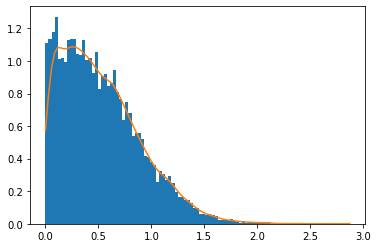

Histogram for F Test feature  1


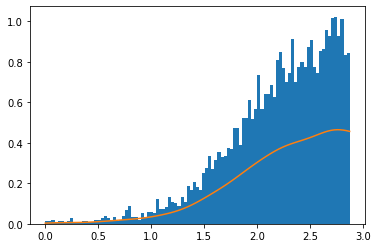

Histogram for F Test feature  2


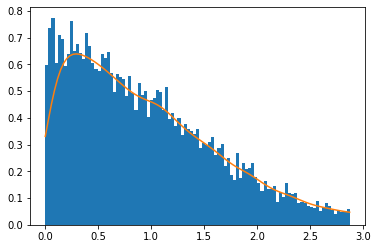

Histogram for F Test feature  3


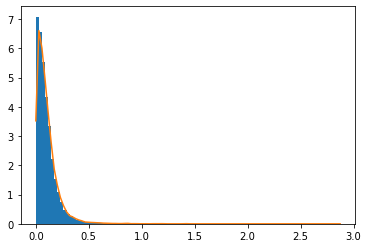

Histogram for F Test feature  4


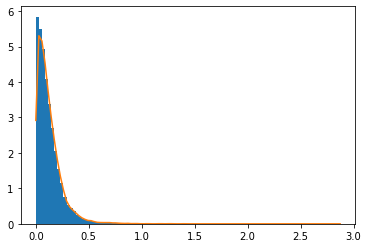

Histogram for F Test feature  5


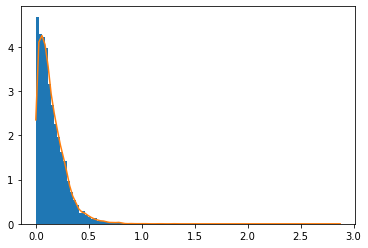

Histogram for F Test feature  6


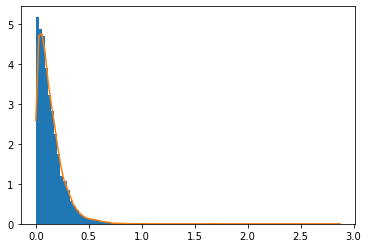

Histogram for F Test feature  7


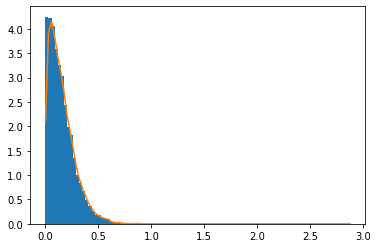

Histogram for F Test feature  8


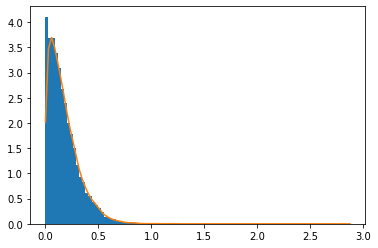

Histogram for F Test feature  9


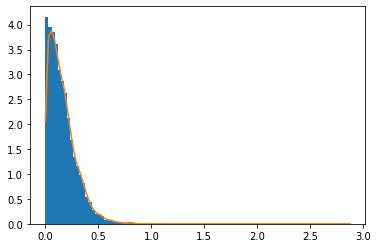

/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Training Accuracy - F:  0.8462
LR Accuracy on test data - F - In Dist:  0.8275
LR Accuracy on test data - F - OOD:  0.0083



Accuracy for without F feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Training Accuracy - F:  0.84604
LR Accuracy on test data - F - In Dist:  0.8279
LR Accuracy on test data - F - OOD:  0.0087


Accuracy for without F feature  1


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Training Accuracy - F:  0.8369
LR Accuracy on test data - F - In Dist:  0.8184
LR Accuracy on test data - F - OOD:  0.0982


Accuracy for without F feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Training Accuracy - F:  0.8466
LR Accuracy on test data - F - In Dist:  0.8276
LR Accuracy on test data - F - OOD:  0.0131


Accuracy for without F feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Training Accuracy - F:  0.84514
LR Accuracy on test data - F - In Dist:  0.827
LR Accuracy on test data - F - OOD:  0.0085


Accuracy for without F feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Training Accuracy - F:  0.84594
LR Accuracy on test data - F - In Dist:  0.8278
LR Accuracy on test data - F - OOD:  0.0091









Results for lamda  100000

Histogram for F Test feature  0


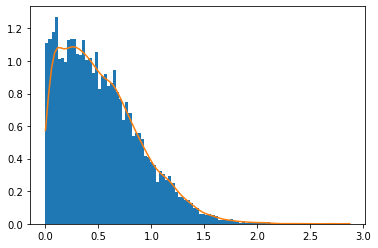

Histogram for F Test feature  1


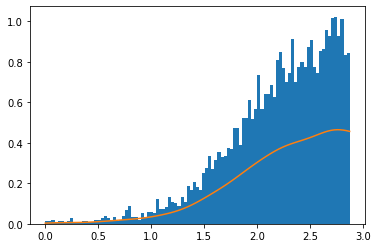

Histogram for F Test feature  2


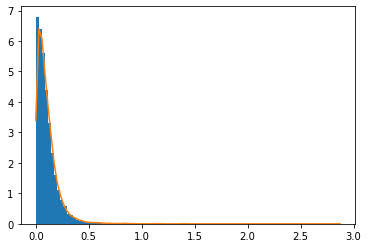

Histogram for F Test feature  3


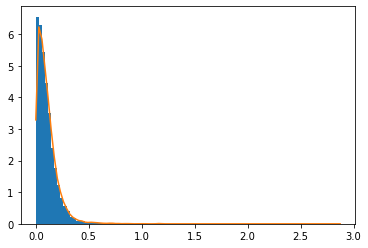

Histogram for F Test feature  4


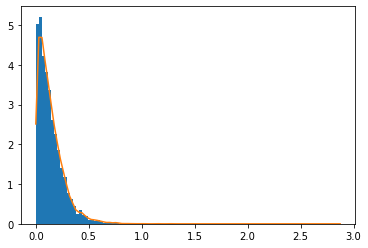

Histogram for F Test feature  5


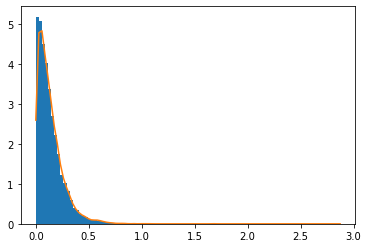

Histogram for F Test feature  6


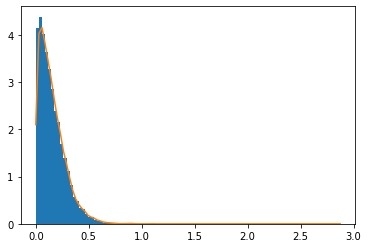

Histogram for F Test feature  7


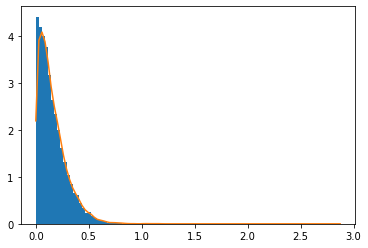

Histogram for F Test feature  8


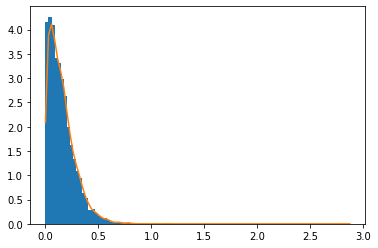

Histogram for F Test feature  9


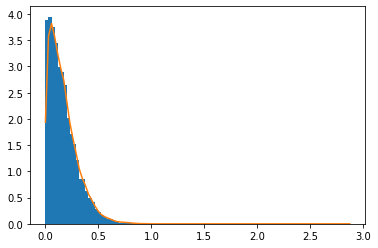

/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Training Accuracy - F:  0.83778
LR Accuracy on test data - F - In Dist:  0.82
LR Accuracy on test data - F - OOD:  0.0133



Accuracy for without F feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Training Accuracy - F:  0.83744
LR Accuracy on test data - F - In Dist:  0.8214
LR Accuracy on test data - F - OOD:  0.0137


Accuracy for without F feature  1


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Training Accuracy - F:  0.82036
LR Accuracy on test data - F - In Dist:  0.8038
LR Accuracy on test data - F - OOD:  0.1293


Accuracy for without F feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Training Accuracy - F:  0.83606
LR Accuracy on test data - F - In Dist:  0.8193
LR Accuracy on test data - F - OOD:  0.013


Accuracy for without F feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Training Accuracy - F:  0.83638
LR Accuracy on test data - F - In Dist:  0.8201
LR Accuracy on test data - F - OOD:  0.0134


Accuracy for without F feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Training Accuracy - F:  0.83708
LR Accuracy on test data - F - In Dist:  0.8198
LR Accuracy on test data - F - OOD:  0.013









Results for lamda  10000000

Histogram for F Test feature  0


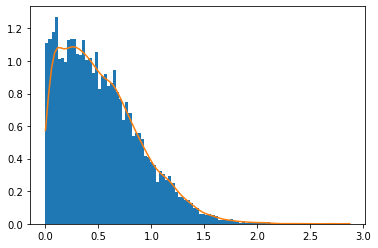

Histogram for F Test feature  1


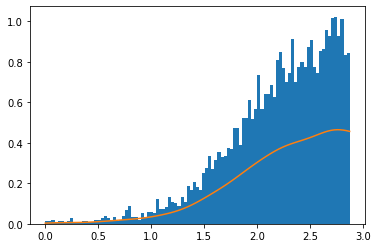

Histogram for F Test feature  2


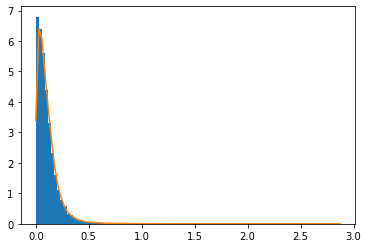

Histogram for F Test feature  3


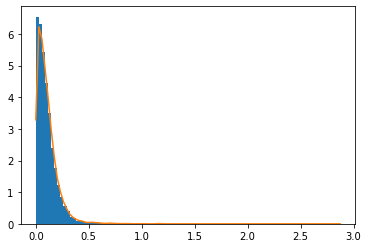

Histogram for F Test feature  4


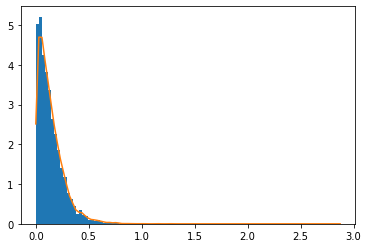

Histogram for F Test feature  5


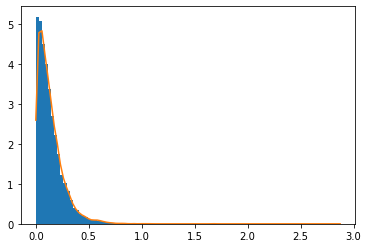

Histogram for F Test feature  6


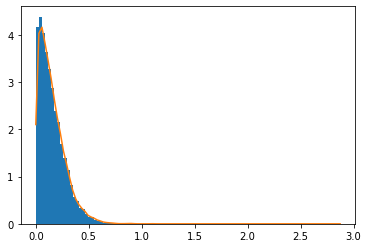

Histogram for F Test feature  7


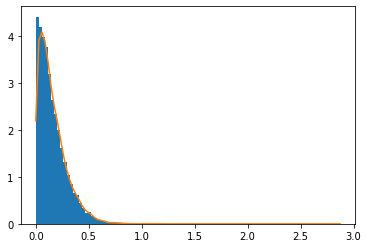

Histogram for F Test feature  8


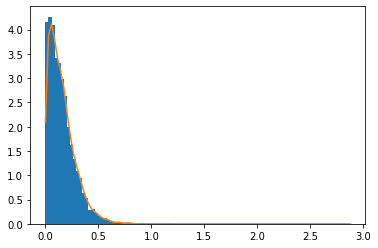

Histogram for F Test feature  9


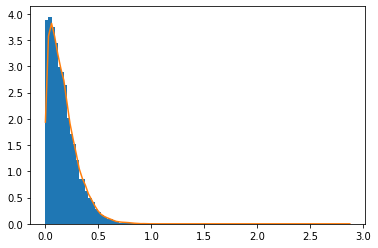

/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Training Accuracy - F:  0.83754
LR Accuracy on test data - F - In Dist:  0.8195
LR Accuracy on test data - F - OOD:  0.0132



Accuracy for without F feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Training Accuracy - F:  0.83716
LR Accuracy on test data - F - In Dist:  0.8208
LR Accuracy on test data - F - OOD:  0.0138


Accuracy for without F feature  1


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Training Accuracy - F:  0.82026
LR Accuracy on test data - F - In Dist:  0.8034
LR Accuracy on test data - F - OOD:  0.1296


Accuracy for without F feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Training Accuracy - F:  0.8361
LR Accuracy on test data - F - In Dist:  0.8193
LR Accuracy on test data - F - OOD:  0.0129


Accuracy for without F feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Training Accuracy - F:  0.83658
LR Accuracy on test data - F - In Dist:  0.8207
LR Accuracy on test data - F - OOD:  0.0136


Accuracy for without F feature  4
LR Training Accuracy - F:  0.83766
LR Accuracy on test data - F - In Dist:  0.8197
LR Accuracy on test data - F - OOD:  0.0131











/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [9]:
import pandas as pd
from scipy import stats
# Computing M
lamdas = [0.001,0.01,10,100,100000, 10000000]

for lamda in lamdas:
    print("Results for lamda ", lamda)
    print()
    k = int(Z.shape[1]*0.5) # % of original number of features
    n = Z.shape[0]
    
    delta_Z_matrix1 = np.absolute((Z_og_contrasted[:int(len(Z_og_contrasted)/2),:] - Z_og_contrasted[int(len(Z_og_contrasted)/2):,:]))
    delta_Z_matrix2 = np.absolute((Z_og_rotated[:int(len(Z_og_rotated)/2),:] - Z_og_rotated[int(len(Z_og_rotated)/2):,:]))
    
    deltas_sum = lamda * delta_Z_matrix1.T @ delta_Z_matrix1 / (
        n // 2 ) + lamda * delta_Z_matrix2.T @ delta_Z_matrix2 / (
        n // 2 ) 
    M = - Z.T @ Z/n + deltas_sum

    # Computing the term on which we perform SVD
    theta_1_theta_1_T = theta_1 @ theta_1.T
    theta_2_theta_2_T = theta_2 @ theta_2.T
    d = theta_1_theta_1_T.shape[0]
    I = np.identity(d)
    I_minus_theta_theta_Ts_sum = I-theta_1_theta_1_T-theta_2_theta_2_T #-theta_3_theta_3_T
    term_for_SVD = (I_minus_theta_theta_Ts_sum @ M) @ I_minus_theta_theta_Ts_sum


    # Performing SVD to get eigenvectors and eigenvalues
    from numpy import linalg as LA
    eigenvalues, eigenvectors = LA.eigh(term_for_SVD)

    # Forming L from eigenvectors and coeficients of transformations 
    L_1 = theta_1
    L_2 = theta_2
    least_k_eigen_values = eigenvalues[:k]
    least_k_eigen_values[np.absolute(least_k_eigen_values)<0.000001]=0

    non_zero_indeces = None
    if 0 in least_k_eigen_values:
        non_zero_indeces = np.nonzero(least_k_eigen_values)[0]
        least_k_eigen_values_without_0 = least_k_eigen_values[non_zero_indeces]

    else:
        non_zero_indeces = np.nonzero(least_k_eigen_values[:k-2])[0]
        least_k_eigen_values_without_0 = least_k_eigen_values[:k-2]

    L_3 = eigenvectors[:,non_zero_indeces]

    L = np.concatenate((L_1,L_2,L_3), axis=1)

   
    # Obtaining F_test values from extracted image features using numpy's linalg.lstsq function.
    F_train = torch.from_numpy(np.linalg.lstsq(L, Z_train.transpose(), rcond=None)[0].transpose())
    F_test_indist = torch.from_numpy(np.linalg.lstsq(L, Z_test_indist.transpose(), rcond=None)[0].transpose())
    F_test_ood = torch.from_numpy(np.linalg.lstsq(L, Z_test_ood.transpose(), rcond=None)[0].transpose())
    F_test_original = torch.from_numpy(np.linalg.lstsq(L, Z_test_original.transpose(), rcond=None)[0].transpose())
    F_test_contrasted = torch.from_numpy(np.linalg.lstsq(L, Z_test_contrasted.transpose(), rcond=None)[0].transpose())
    

    # Plot histograms
    # the difference between F_test_green and F_test_red
    delta_matrix = np.absolute(F_test_original.detach().numpy() - F_test_contrasted.detach().numpy())
    delta_matrix_df = pd.DataFrame(delta_matrix)

    # Plotting the histograms for each feature in the delta matrix # 100 bins
    for i in range(10): #(len(delta_matrix_df.columns)): 
        print("Histogram for F Test feature ", i)    
        feature = delta_matrix_df.iloc[:,i].values
        density = stats.gaussian_kde(feature)
        n, x, _ = plt.hist(feature, bins=np.linspace(0, np.amax(delta_matrix_df.iloc[:,0]), 100), 
                           histtype='bar', density=True)  
        plt.plot(x, density(x))
        plt.show()
    
    
    # Classification task using F features    
    lr_model1 = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=0).fit(F_train,train_labels2)
    accuracy0 = lr_model1.score(F_train, train_labels2)
    accuracy1 = lr_model1.score(F_test_indist, test_labels2_indist)
    accuracy2 = lr_model1.score(F_test_ood, test_labels2_ood)
    print('LR Training Accuracy - F: ', accuracy0)
    print('LR Accuracy on test data - F - In Dist: ', accuracy1)
    print('LR Accuracy on test data - F - OOD: ', accuracy2)
    print("\n"*2)

    # Removing one feature at a time
    for i in range(5): #(F_test_original.detach().numpy().shape[1]):
        print("Accuracy for without F feature ",i)

        X_train = F_train.detach().numpy().copy()
        X_test_indist = F_test_indist.detach().numpy().copy()
        X_test_ood = F_test_ood.detach().numpy().copy()

        X_train = np.delete(X_train, i, 1)
        X_test_indist = np.delete(X_test_indist, i, 1)
        X_test_ood = np.delete(X_test_ood, i, 1)
       

        lr_model2 = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=0).fit(X_train,train_labels2)
        accuracy0 = lr_model2.score(X_train, train_labels2)
        accuracy1 = lr_model2.score(X_test_indist, test_labels2_indist)
        accuracy2 = lr_model2.score(X_test_ood, test_labels2_ood)
        print('LR Training Accuracy - F: ', accuracy0)
        print('LR Accuracy on test data - F - In Dist: ', accuracy1)
        print('LR Accuracy on test data - F - OOD: ', accuracy2)

        print("\n"*1)
    print("\n"*6)


